# (Almost) Real -Time TWITTER Sentiment Analysis with Tweep & Vader
by Marcelo Rovai 

In [29]:
import time
import re
import pandas as pd
import nltk
from nltk.stem.porter import *
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Vader

In [50]:
import requests
import json
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

In [51]:
 analyser.polarity_scores("The movie is good")

{'compound': 0.4404, 'neg': 0.0, 'neu': 0.508, 'pos': 0.492}

In [52]:
 analyser.polarity_scores("The movie is bad")

{'compound': -0.5423, 'neg': 0.538, 'neu': 0.462, 'pos': 0.0}

In [54]:
 analyser.polarity_scores("The movie is very bad")

{'compound': -0.5849, 'neg': 0.487, 'neu': 0.513, 'pos': 0.0}

In [55]:
 analyser.polarity_scores("The movie is VERY BAD")

{'compound': -0.7398, 'neg': 0.568, 'neu': 0.432, 'pos': 0.0}

In [59]:
 analyser.polarity_scores("The movie is VERY BAD!!!")

{'compound': -0.7984, 'neg': 0.605, 'neu': 0.395, 'pos': 0.0}

In [60]:
def sentiment_analyzer_scores(text):
    score = analyser.polarity_scores(text)
    lb = score['compound']
    if lb >= 0.05:
        return 1
    elif (lb > -0.05) and (lb < 0.05):
        return 0
    else:
        return -1

In [62]:
sentiment_analyzer_scores("The movie is VERY BAD!!!")

-1

In [63]:
sentiment_analyzer_scores("The movie is VERY GOOD!!!")

1

In [64]:
sentiment_analyzer_scores("The movie is long")

0

## Visualization of dataset with WordCloud

In [116]:
def word_cloud(wd_list):
    stopwords = set(STOPWORDS)
    all_words = ' '.join([text for text in wd_list])
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        width=1600,
        height=800,
        random_state=21,
        colormap='jet',
        max_words=50,
        max_font_size=200).generate(all_words)

    plt.figure(figsize=(12, 10))
    plt.axis('off')
    plt.imshow(wordcloud, interpolation="bilinear");

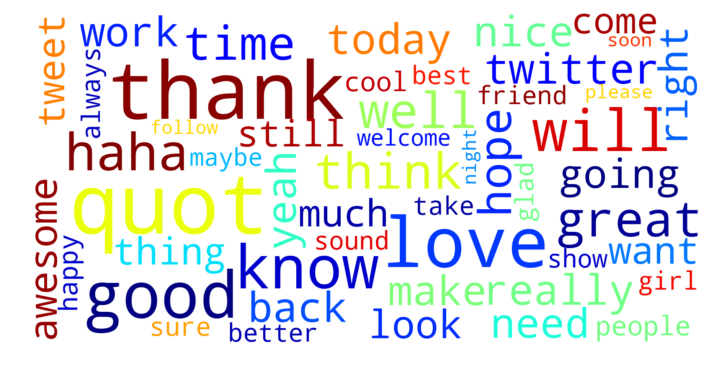

In [205]:
#Positive - Original dataset
tw_pos = df_tw[df_tw['Sentiment'] == 1]['SentimentText']
word_cloud(tw_pos)

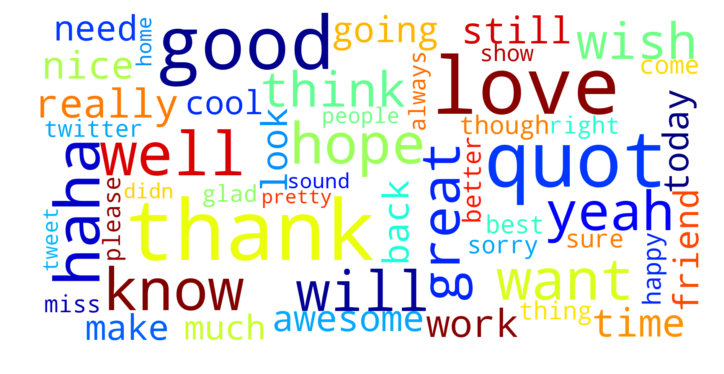

In [203]:
#Positive Vader
tw_pos = df_tw[df_tw['sent'] == 1]['SentimentText']
word_cloud(tw_pos)

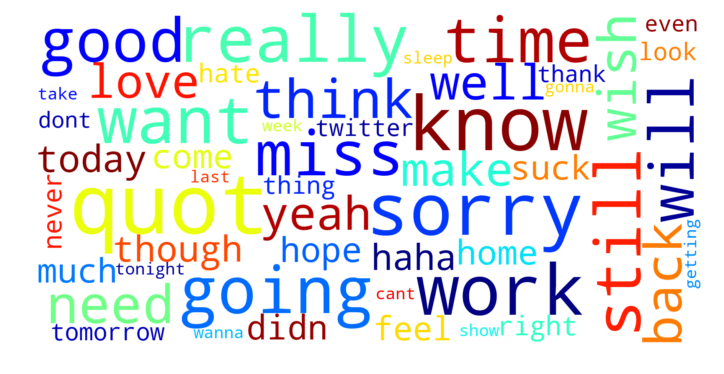

In [206]:
#Negative - Original dataset
tw_pos = df_tw[df_tw['Sentiment'] == 0]['SentimentText']
word_cloud(tw_pos)

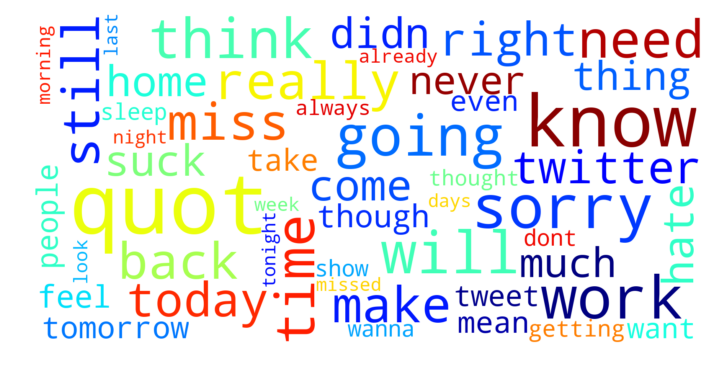

In [207]:
#Negative Vader
tw_pos = df_tw[df_tw['sent'] == 0]['SentimentText']
word_cloud(tw_pos)

## Using Vader in other languages

### Googletrans
Googletrans is a free and unlimited python library that implemented Google Translate API. This uses the Google Translate Ajax API to make calls to such methods as detect and translate.

In [65]:
from googletrans import Translator
translator = Translator()

In [66]:
translator.translate('hola, todo bien?').text

'hello, all right?'

In [69]:
text = translator.translate('la pelicula es mala').text
analyser.polarity_scores(text)

{'compound': -0.5423, 'neg': 0.538, 'neu': 0.462, 'pos': 0.0}

In [70]:
text

'the movie is bad'

In [228]:
trans = translator.translate('hola, todo bien?')
type(trans.text)

str

In [78]:
def sentiment_analyzer_scores(text, engl=True):
    if engl:
        trans = text
    else:
        trans = translator.translate(text).text

    score = analyser.polarity_scores(trans)
    lb = score['compound']
    if lb >= 0.05: return 1
    elif (lb > -0.05) and (lb < 0.05): return 0
    else: return -1

In [79]:
text = 'the movie is very good'
sentiment_analyzer_scores(text)

1

In [81]:
text = 'es muy buena la peli'
sentiment_analyzer_scores(text, False)

1

In [82]:
text = 'es muy mala la peli'
sentiment_analyzer_scores(text, False)

-1

In [83]:
text = 'o dia esta bem ruim'
sentiment_analyzer_scores(text, False)

-1

In [89]:
translator.translate('o dia esta lindo, com muito sol').text

'the day is beautiful, with a lot of sun'

In [85]:
text = 'o mar é azul'
sentiment_analyzer_scores(text, False)

0

# Twitter

In [9]:
import sys
import tweepy
import csv

In [10]:
consumer_key = 'YOUR KEY HERE'
consumer_secret = 'YOUR KEY HERE'
access_token = 'YOUR KEY HERE'
access_token_secret = 'YOUR KEY HERE'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth)

### Reading tweets from an id  

In [90]:
tweets = api.user_timeline('@ingenieriaUDD_', count=5, tweet_mode='extended')
for t in tweets:
    print(t.full_text)
    print()

Todas nuestras carreras están entre las mejores pagadas del país. Desde el 5to año de egreso, Ingeniería Civil en Minas, Geología, Ingeniería Civil plan común e Ingeniería Civil Industrial lideran el ranking elaborado por Portal Mi Futuro. ✓ https://t.co/wKcvPPVL85

Mi gran sueño es que el made in Saltillo se cambie a mind in Saltillo y se lleve a toda la región (...) sólo hace falta concentración para lograr este cambio y ponerlo en el panorama educativo". Ulises Valencia de Invader Institute habla sobre creatividad en #DemandSolutions

"Nuestra escuela está fundamentada en 3 elementos: el primero no buscamos algo escrito previamente, buscamos nuevas incógnitas y participar de él de manera creativa" Ulises Valencia, Director y cofundador de Invader Institute en #DemandSolutions

¿Cómo formar creativos digitales? Ulises Valencia de Invader Institute en #DemandSolutions

Liz Powers se preguntó cómo redefinir lo que es un trabajo para integrar a más personas a la economía. Así luego naci

## Create a List of Tweets 

In [11]:
def list_tweets(user_id, count, prt=False):
    tweets = api.user_timeline(
        "@" + user_id, count=count, tweet_mode='extended')
    tw = []
    for t in tweets:
        tw.append(t.full_text)
        if prt:
            print(t.full_text)
            print()
    return tw

In [107]:
user_id = 'realDonaldTrump' 
count=200

In [108]:
tw_trump = list_tweets(user_id, count)

In [97]:
type(tw_trump)

list

In [109]:
tw_trump[2]

'.@FLOTUS Melania and I were honored to visit our incredible troops at Al Asad Air Base in Iraq. GOD BLESS THE U.S.A.! https://t.co/rDlhITDvm1'

## Cleaning Twitter Dataset

In [146]:
def clean_tweets(lst):
    # remove twitter Return handles (RT @xxx:)
    lst = np.vectorize(remove_pattern)(lst, "RT @[\w]*:")
    # remove twitter handles (@xxx)
    lst = np.vectorize(remove_pattern)(lst, "@[\w]*")
    # remove URL links (httpxxx)
    lst = np.vectorize(remove_pattern)(lst, "https?://[A-Za-z0-9./]*")
    # remove special characters, numbers, punctuations (except for #)
    lst = np.core.defchararray.replace(lst, "[^a-zA-Z#]", " ")

    return lst

In [136]:
tw_trump = clean_tweets(tw_trump)

In [137]:
tw_trump[2]

'. Melania and I were honored to visit our incredible troops at Al Asad Air Base in Iraq. GOD BLESS THE U.S.A.! '

## Analizing Twetts sentiment

In [104]:
sentiment_analyzer_scores(tw_trump[2])

1

In [114]:
def anl_tweets(lst, title='Tweets Sentiment', engl=True ):
    sents = []
    for tw in lst:
        try:
            st = sentiment_analyzer_scores(tw, engl)
            sents.append(st)
        except:
            sents.append(0)
    ax = sns.distplot(
        sents,
        kde=False,
        bins=3)
    ax.set(xlabel='Negative                Neutral                 Positive',
           ylabel='#Tweets',
          title="Tweets of @"+title)
    return sents

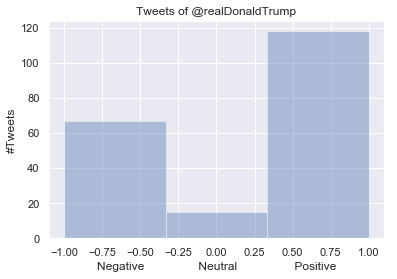

In [115]:
tw_trump_sent = anl_tweets(tw_trump, user_id)

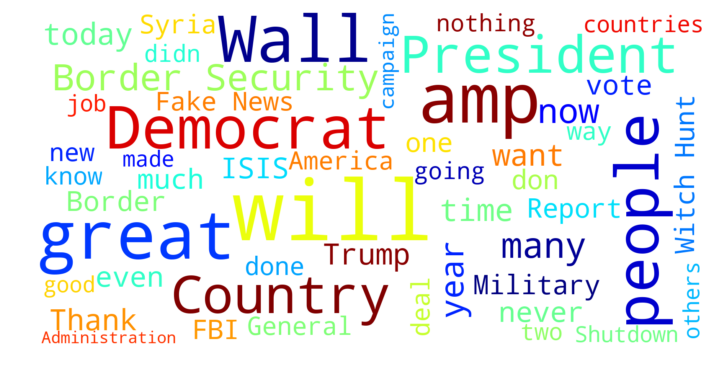

In [117]:
word_cloud(tw_trump)

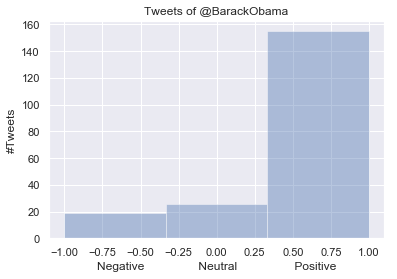

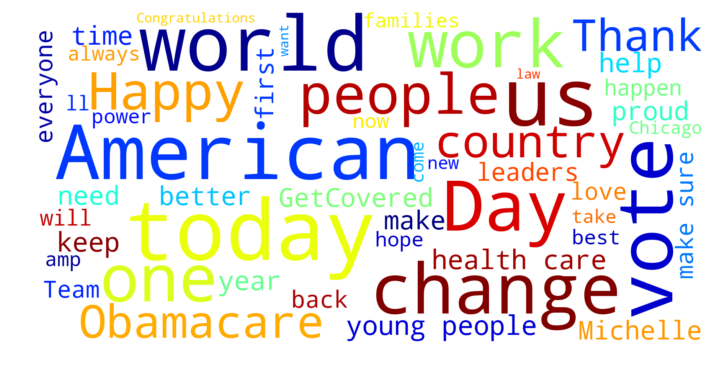

In [138]:
user_id = 'BarackObama' 
tw_obama = list_tweets(user_id, count)
tw_obama = clean_tweets(tw_obama)
tw_obama_sent = anl_tweets(tw_obama, user_id)
word_cloud(tw_obama)

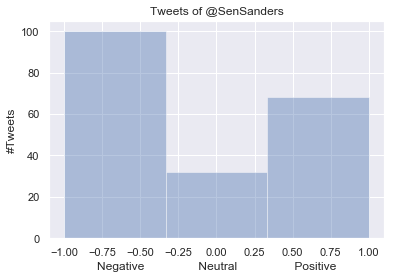

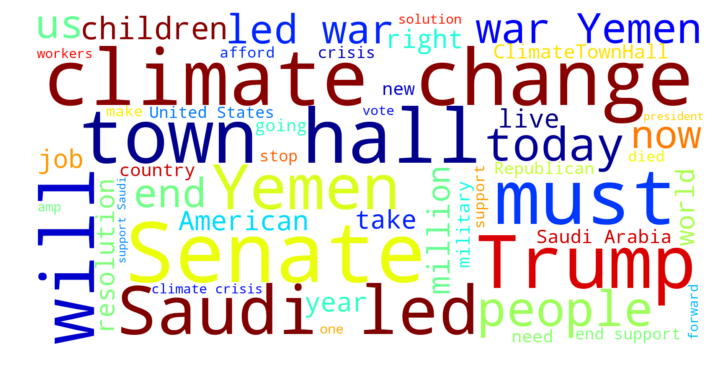

In [139]:
user_id = 'SenSanders' 
tw_sanders = list_tweets(user_id, count)
tw_sanders = clean_tweets(tw_sanders)
tw_sanders_sent = anl_tweets(tw_sanders, user_id)
word_cloud(tw_sanders)

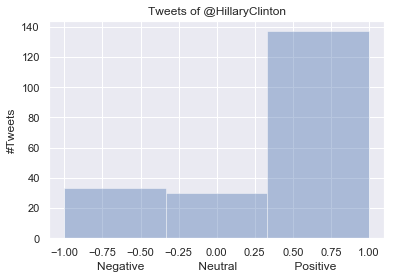

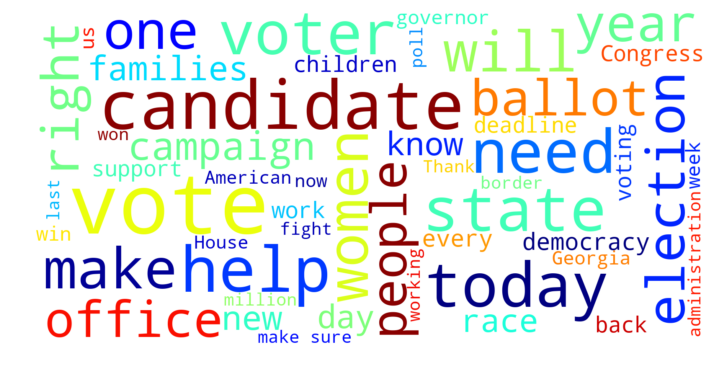

In [140]:
user_id = 'HillaryClinton' 
tw_hillary = list_tweets(user_id, count)
tw_hillary = clean_tweets(tw_hillary)
tw_hillary_sent = anl_tweets(tw_hillary, user_id)
word_cloud(tw_hillary)

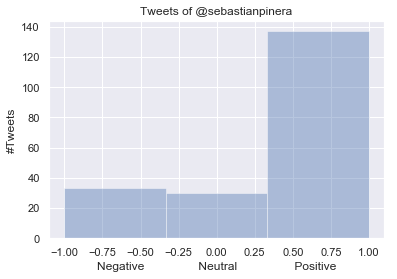

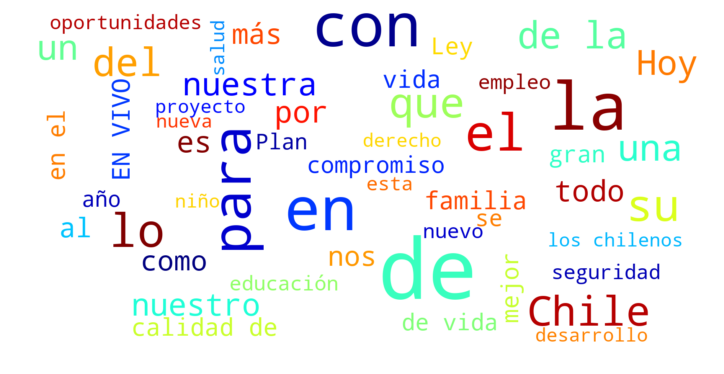

In [171]:
user_id = 'sebastianpinera' 
tw_pinera = list_tweets(user_id, count)
tw_pinera = clean_tweets(tw_pinera)
tw_pinera_sent = anl_tweets(tw_pinera, user_id, False)
word_cloud(tw_pinera)

---

# Tweepy StreamListener to CSV

To stop this code, you must end the cell run

Thanks to:
https://stackoverflow.com/questions/38281076/tweepy-streamlistener-to-csv

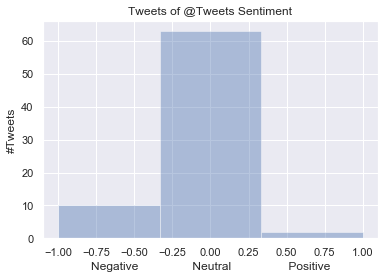

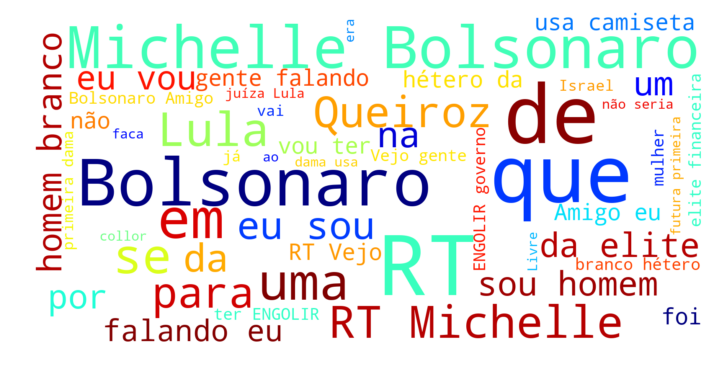

In [26]:
df_text = pd.read_csv(file_name)
tweets = clean_tweets(df_text.Text)
tweets_sent = anl_tweets(tweets)
word_cloud(tweets)

---

## Open a file and starts streaming for a specific filter during a delta time

## track
A comma-separated list of phrases which will be used to determine what Tweets will be delivered on the stream. A phrase may be one or more terms separated by spaces, and a phrase will match if all of the terms in the phrase are present in the Tweet, regardless of order and ignoring case. By this model, you can think of commas as logical ORs, while spaces are equivalent to logical ANDs (e.g. ‘the twitter’ is the AND twitter, and ‘the,twitter’ is the OR twitter).

## language
This parameter may be used on all streaming endpoints, unless explicitly noted.
Setting this parameter to a comma-separated list of BCP 47 language identifiers corresponding to any of the languages listed on Twitter’s advanced search page will only return Tweets that have been detected as being written in the specified languages. For example, connecting with language=en will only stream Tweets detected to be in the English language. Other language codes:
- en: English
- es: Spanish
- pt: Portuguese

## follow
A comma-separated list of user IDs, indicating the users whose Tweets should be delivered on the stream. Following protected users is not supported. For each user specified, the stream will contain:
- Tweets created by the user.
- Tweets which are retweeted by the user.
- Replies to any Tweet created by the user.
- Retweets of any Tweet created by the user.
- Manual replies, created without pressing a reply button (e.g. “@twitterapi I agree”).

## locations
A comma-separated list of longitude,latitude pairs specifying a set of bounding boxes to filter Tweets by. Only geolocated Tweets falling within the requested bounding boxes will be included—unlike the Search API, the user’s location field is not used to filter Tweets.
Each bounding box should be specified as a pair of longitude and latitude pairs, with the southwest corner of the bounding box coming first. For example:

- -122.75,36.8,-121.75,37.8	==> San Francisco
- -74,40,-73,41	==> New York City
- -122.75,36.8,-121.75,37.8,-74,40,-73,41 ==> San Francisco OR New York City

In [126]:
def twitter_stream_listener(file_name,
                            filter_track,
                            follow=None,
                            locations=None,
                            languages=None,
                            time_limit=20):
    class CustomStreamListener(tweepy.StreamListener):
        def __init__(self, time_limit):
            self.start_time = time.time()
            self.limit = time_limit
            # self.saveFile = open('abcd.json', 'a')
            super(CustomStreamListener, self).__init__()

        def on_status(self, status):
            if (time.time() - self.start_time) < self.limit:
                print(".", end="")
                # Writing status data
                with open(file_name, 'a') as f:
                    writer = csv.writer(f)
                    writer.writerow([
                        status.author.screen_name, status.created_at,
                        status.text
                    ])
            else:
                print("\n\n[INFO] Closing file and ending streaming")
                return False

        def on_error(self, status_code):
            if status_code == 420:
                print('Encountered error code 420. Disconnecting the stream')
                # returning False in on_data disconnects the stream
                return False
            else:
                print('Encountered error with status code: {}'.format(
                    status_code))
                return True  # Don't kill the stream

        def on_timeout(self):
            print('Timeout...')
            return True  # Don't kill the stream

    # Writing csv titles
    print(
        '\n[INFO] Open file: [{}] and starting {} seconds of streaming for {}\n'
        .format(file_name, time_limit, filter_track))
    with open(file_name, 'w') as f:
        writer = csv.writer(f)
        writer.writerow(['author', 'date', 'text'])

    streamingAPI = tweepy.streaming.Stream(
        auth, CustomStreamListener(time_limit=time_limit))
    streamingAPI.filter(
        track=filter_track,
        follow=follow,
        locations=locations,
        languages=languages,
    )
    f.close()

In [129]:
filter_track = ['trump', 'wall']
file_name = 'tweets_trump_wall.csv'
twitter_stream_listener (file_name, filter_track, time_limit=60)


[INFO] Open file: [tweets_trump_wall.csv] and starting 60 seconds of streaming for ['trump', 'wall']

.................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

## Convert CVS file to dataframe and clean data

In [156]:
file_name = 'tweets_trump_wall.csv'
df_tws = pd.read_csv(file_name)
df_tws.shape

(2576, 3)

In [157]:
df_tws.head()

,author,date,text
0,suetsam,2018-12-27 19:03:47,RT @SethAbramson: 25/ I'm just going to stop t...
1,jcforjc7,2018-12-27 19:03:47,"RT @bennyjohnson: Here, CNN asks if troops ser..."
2,jmksd,2018-12-27 19:03:47,RT @Jenn198523: MSM PROVEN WRONG......AGAIN!\n...
3,jane_ERRN,2018-12-27 19:03:47,RT @TrinityResists: @Trinitythecat MAGA is his...
4,ThePaladin00,2018-12-27 19:03:47,My grandmother lost her entire retirement fund...


In [158]:
df_tws['text'] =  clean_tweets(df_tws['text'])

In [159]:
df_tws.head()

,author,date,text
0,suetsam,2018-12-27 19:03:47,25/ I'm just going to stop this thread here—a...
1,jcforjc7,2018-12-27 19:03:47,"Here, CNN asks if troops serving in a war zon..."
2,jmksd,2018-12-27 19:03:47,MSM PROVEN WRONG......AGAIN!\nPresident Trump...
3,jane_ERRN,2018-12-27 19:03:47,MAGA is his campaign slogan. He registered t...
4,ThePaladin00,2018-12-27 19:03:47,My grandmother lost her entire retirement fund...


## Create a new column with sentiment score

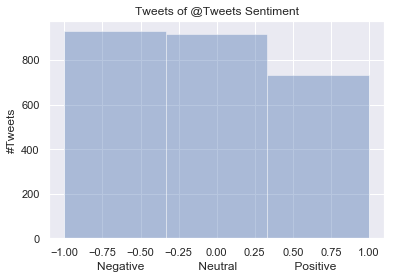

In [160]:
df_tws['sent'] = anl_tweets(df_tws.text)

In [161]:
df_tws.head()

,author,date,text,sent
0,suetsam,2018-12-27 19:03:47,25/ I'm just going to stop this thread here—a...,-1
1,jcforjc7,2018-12-27 19:03:47,"Here, CNN asks if troops serving in a war zon...",-1
2,jmksd,2018-12-27 19:03:47,MSM PROVEN WRONG......AGAIN!\nPresident Trump...,0
3,jane_ERRN,2018-12-27 19:03:47,MAGA is his campaign slogan. He registered t...,0
4,ThePaladin00,2018-12-27 19:03:47,My grandmother lost her entire retirement fund...,1


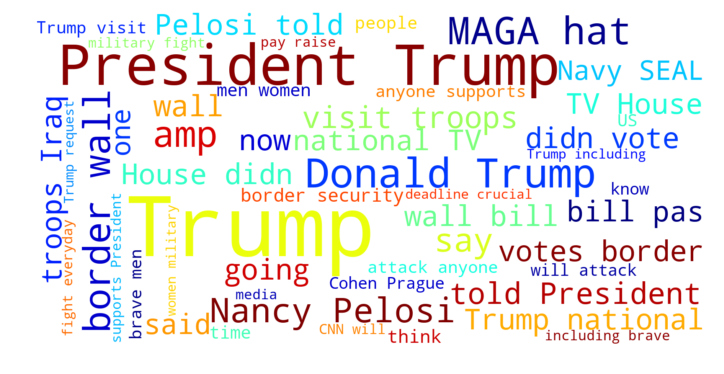

In [162]:
word_cloud(df_tws.text)

## Exploring positives and negatives tweets

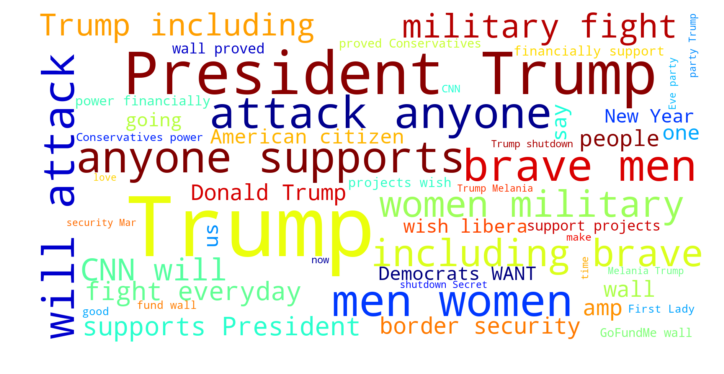

In [164]:
# Words in positive tweets
tws_pos = df_tws['text'][df_tws['sent'] == 1]
word_cloud(tws_pos)

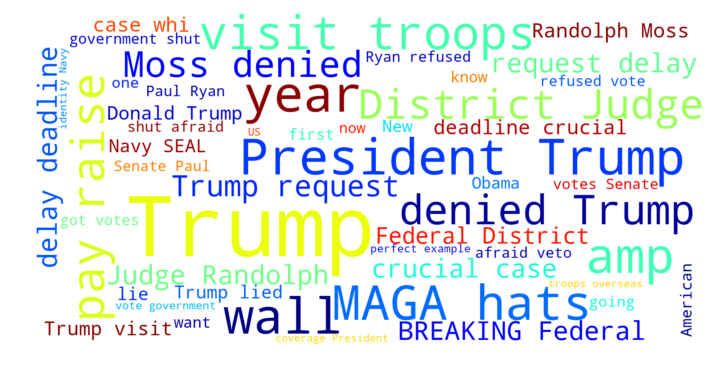

In [165]:
# Words in negative tweets
tws_pos = df_tws['text'][df_tws['sent'] == -1]
word_cloud(tws_pos)

In [166]:
# function to collect hashtags
def hashtag_extract(x):
    hashtags = []
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)
    return hashtags

In [167]:
# extracting hashtags from positive tweets

HT_positive = hashtag_extract(df_tws['text'][df_tws['sent'] == 1])

# extracting hashtags from negative tweets
HT_negative = hashtag_extract(df_tws['text'][df_tws['sent'] == -1])

# unnesting list
HT_positive = sum(HT_positive,[])
HT_negative = sum(HT_negative,[])

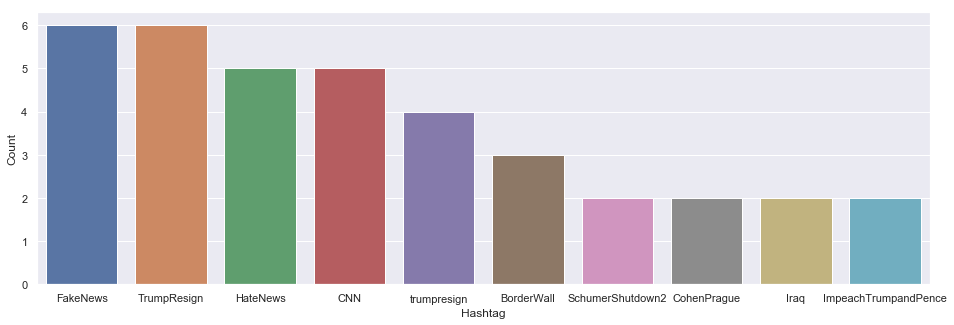

In [168]:
# Positive Tweets

a = nltk.FreqDist(HT_positive)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})
# selecting top 10 most frequent hashtags     
d = d.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

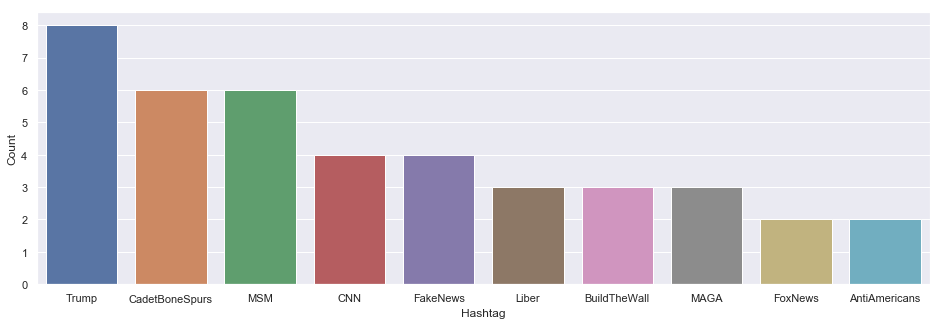

In [169]:
# Negative Tweets

b = nltk.FreqDist(HT_negative)
e = pd.DataFrame({'Hashtag': list(b.keys()), 'Count': list(b.values())})
# selecting top 10 most frequent hashtags
e = e.nlargest(columns="Count", n = 10)   
plt.figure(figsize=(16,5))
ax = sns.barplot(data=e, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()